## Algorithmic Trading using Recurrent Proximal Policy Optimisation (PPO)

This reinforcement learning project is to demonstrate the application of AI in trading.

First, we will import the necessary libraries. We will use <a href='https://github.com/AminHP/gym-anytrading'>AnyTrading</a> library from OpenAI Gym to setup the stock trading environment and <a href='https://stable-baselines3.readthedocs.io/en/master/'>Stable-Baselines3</a> library for recurrent PPO algorithm.

In [2]:
# Import necessary dependencies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

import gym
import gym_anytrading

from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv

### Data Collection

The data that we will use consist of GameStop stock prices.<br> Source: https://www.marketwatch.com/investing/stock/gme/download-data?startDate=1/3/2022&endDate=09/14/2022

In [3]:
df = pd.read_csv('gmedata.csv')
df

,Date,Open,High,Low,Close,Volume
0,09/14/2022,27.56,28.45,26.65,28.13,"3,605,752"
1,09/13/2022,27.40,28.61,27.32,27.85,"3,657,164"
2,09/12/2022,29.03,30.34,28.00,29.24,"6,175,210"
3,09/09/2022,26.30,29.08,26.10,28.92,"7,916,490"
4,09/08/2022,25.00,26.74,24.07,25.83,"14,142,210"
...,...,...,...,...,...,...
248,09/20/2021,50.00,50.71,46.14,48.05,"15,767,208"
249,09/17/2021,52.01,53.12,50.20,51.24,"15,802,572"
250,09/16/2021,50.58,54.14,50.29,51.59,"12,232,868"
251,09/15/2021,49.25,51.22,48.44,51.13,"9,241,628"


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume            object
dtype: object

In [5]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-09-14,27.56,28.45,26.65,28.13,"3,605,752"
2022-09-13,27.40,28.61,27.32,27.85,"3,657,164"
2022-09-12,29.03,30.34,28.00,29.24,"6,175,210"
2022-09-09,26.30,29.08,26.10,28.92,"7,916,490"
2022-09-08,25.00,26.74,24.07,25.83,"14,142,210"


### Environment Set Up

The parameter window_size is the number of ticks (current and previous ticks) returned as observation/state. For example, window_size = 5 means the data of the current day + 4 days before.<br>
The parameter frame_bound is the range of data to be considered in the dataset, df.

In [6]:
window_size = 12
start_index = window_size
end_index = 120

In [7]:
env_maker = lambda: gym.make(
    'stocks-v0',
    df=df, 
    frame_bound=(start_index, end_index), 
    window_size=window_size
)

In [8]:
env = DummyVecEnv([env_maker])

There are two possible actions in the trading environment: 0 = sell and 1 = buy.

In [9]:
env = env_maker()

In [10]:
env.action_space

Discrete(2)

In [11]:
env.signal_features

array([[ 2.813e+01,  0.000e+00],
       [ 2.785e+01, -2.800e-01],
       [ 2.924e+01,  1.390e+00],
       [ 2.892e+01, -3.200e-01],
       [ 2.583e+01, -3.090e+00],
       [ 2.404e+01, -1.790e+00],
       [ 2.514e+01,  1.100e+00],
       [ 2.736e+01,  2.220e+00],
       [ 2.763e+01,  2.700e-01],
       [ 2.864e+01,  1.010e+00],
       [ 2.984e+01,  1.200e+00],
       [ 3.155e+01,  1.710e+00],
       [ 3.094e+01, -6.100e-01],
       [ 3.196e+01,  1.020e+00],
       [ 3.250e+01,  5.400e-01],
       [ 3.353e+01,  1.030e+00],
       [ 3.450e+01,  9.700e-01],
       [ 3.649e+01,  1.990e+00],
       [ 3.793e+01,  1.440e+00],
       [ 4.052e+01,  2.590e+00],
       [ 4.219e+01,  1.670e+00],
       [ 3.968e+01, -2.510e+00],
       [ 4.074e+01,  1.060e+00],
       [ 3.945e+01, -1.290e+00],
       [ 4.053e+01,  1.080e+00],
       [ 4.037e+01, -1.600e-01],
       [ 4.345e+01,  3.080e+00],
       [ 4.002e+01, -3.430e+00],
       [ 3.836e+01, -1.660e+00],
       [ 3.793e+01, -4.300e-01],
       [ 3

### Model Training

For the training, we will use the Proximal Policy Optimization (PPO) algorithm. It combines ideas from A2C (having multiple workers) and TRPO (it uses a trust region to improve the actor). In particular, we use the recurrent PPO which supports recurrent policies (LSTM).

Source: https://sb3-contrib.readthedocs.io/en/master/modules/ppo_recurrent.html

In [ ]:
model = RecurrentPPO("MlpLstmPolicy", env, verbose=0)
model.learn(total_timesteps=15000)

In [ ]:
model.save('StockTrading')

In [ ]:
del model

The StockTrading zip file inside the repository contains the pre-learned model with total timesteps of 15000. So, we can load the model from it.

In [12]:
model = RecurrentPPO.load('StockTrading')

In [13]:
# Set the environment back
model.set_env(env_maker())

### Model Testing

In [14]:
# Cell and hidden states of the LSTM
lstm_states = None
num_envs = 1

# Episode start signals are used to reset the lstm states
episode_starts = np.ones((num_envs,), dtype=bool)

In [15]:
obs = env.reset()                                # Initial state/observation of the environment

while True:
    obs = obs[np.newaxis, ...]

    action, lstm_states = model.predict(obs, state=lstm_states,
                                       episode_start=episode_starts)  
    # Based on the state in lstm, do action and go to the next state

    obs, reward, done, info = env.step(action)   # Next state and reward

    # env.render()
    episode_starts = done
    if done:
        print("info:", info)
        break

info: {'total_reward': 4.359999999999999, 'total_profit': 0.9376816033987575, 'position': 0}


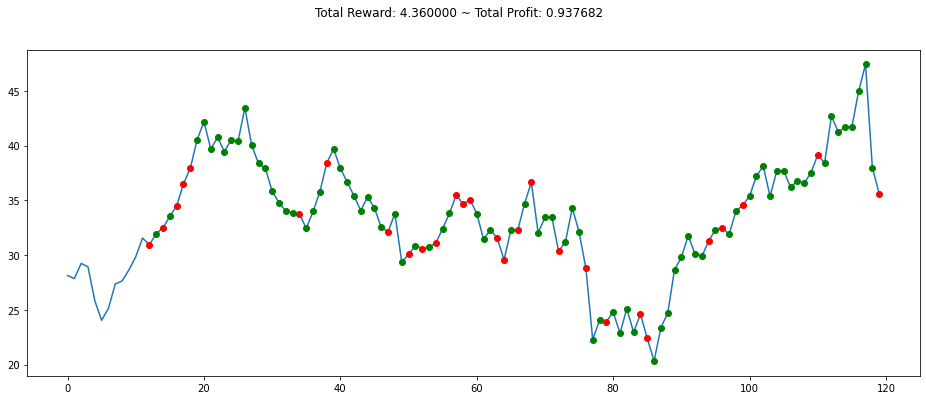

In [16]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

At the beginning, we started with a profit of 1, and after this algorithmic trading from the 12th day to the 120th day, we ended with a profit of 0.937682. In this case, we suffered a loss.

### Evaluation

For evaluation, we use another range of data, 130th to 160th days of data.

In [17]:
window_size = 12
start_index = 130
end_index = 160

We crop the original dataframe such that it includes only 118th to 160th data (12 days before 130th day).

In [18]:
evaluationDF = pd.DataFrame(df[start_index-window_size:end_index])

In [19]:
evaluationDF.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-03-25,35.01,39.54,34.55,37.99,"53,535,480"
2022-03-24,33.50,35.87,31.69,35.60,"36,400,600"
2022-03-23,32.50,37.73,31.64,35.25,"98,399,360"
2022-03-22,23.85,31.45,23.61,30.79,"60,068,920"
2022-03-21,22.50,24.85,22.44,23.55,"15,812,448"


In [20]:
env_maker = lambda: gym.make(
    'stocks-v0',
    df=df, 
    frame_bound=(start_index, end_index), 
    window_size=window_size
)

env = DummyVecEnv([env_maker])
env = env_maker()

In [21]:
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, lstm_states = model.predict(obs, state=lstm_states, 
                                       episode_start=episode_starts)
    obs, rewards, done, info = env.step(action)
    episode_starts = done
    if done:
        print("info", info)
        break

info {'total_reward': 1.3100000000000023, 'total_profit': 0.9840327063379151, 'position': 0}


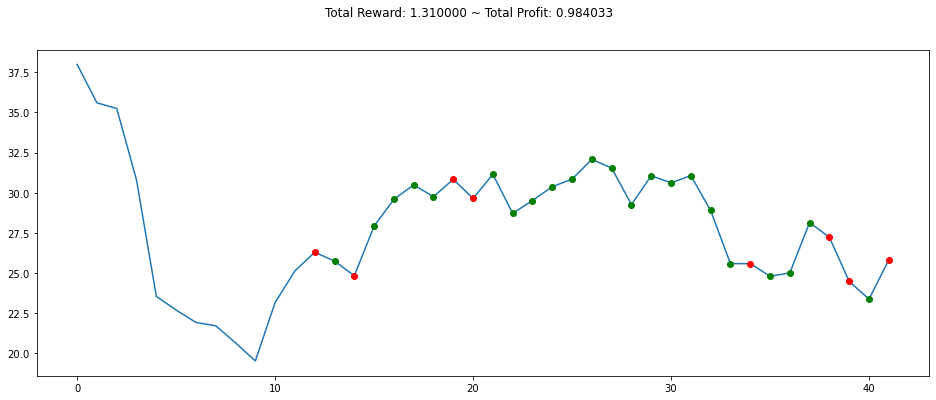

In [22]:
plt.figure(figsize=(16,6))

env.render_all()
plt.show()

After this algorithmic trading from the 130th day to the 160th day, we ended with a profit of 0.984033. In this case, again, we suffered a loss.

### Extend and Manipulate the Trading Environment with Custom Indicators

For the next part, we will try to improve the model by using different indicators to guide the trading. For this, we will use finta library.

In [23]:
from gym_anytrading.envs import StocksEnv
from finta import TA

The values of the volume column in the data are separated ',', so we will remove this and convert them to float values.

In [24]:
df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(",", "")))

In [25]:
df.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

The custom indicators that we will use are SMA, RSI and OBV. Click on the term to go to the reference page.
<ul>
    <li><a href='https://www.investopedia.com/terms/s/sma.asp'>Simple-Moving Average (SMA)</a>: The average of a selected range of prices, usually closing prices, by the number of periods in that range.
   </li>
    <li><a href='https://www.investopedia.com/terms/r/rsi.asp'>Relative Strength Index (RSI)</a>: Measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security.
   </li>
   <li><a href='https://www.investopedia.com/terms/o/onbalancevolume.asp'>On-Balance Volume (OBV)</a>: Uses volume flow to predict changes in stock price. 
   </li>
</ul>

For our SMA, it will be a 12-day moving average.

In [26]:
# Calculating and implementing the indicators
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)

In [27]:
df.head(15)

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2022-09-14,27.56,28.45,26.65,28.13,3605752.0,NaN,NaN,NaN
2022-09-13,27.40,28.61,27.32,27.85,3657164.0,NaN,0.000000,-3657164.0
2022-09-12,29.03,30.34,28.00,29.24,6175210.0,NaN,84.242424,2518046.0
2022-09-09,26.30,29.08,26.10,28.92,7916490.0,NaN,69.687621,-5398444.0
2022-09-08,25.00,26.74,24.07,25.83,14142210.0,NaN,24.918057,-19540654.0
2022-09-07,24.73,25.19,23.42,24.04,12504680.0,NaN,17.788697,-32045334.0
2022-09-06,25.75,26.72,24.67,25.14,7010190.0,NaN,30.876999,-25035144.0
2022-09-02,28.26,28.74,26.93,27.36,4680123.0,NaN,48.646244,-20355021.0
2022-09-01,28.00,28.91,26.95,27.63,5293858.0,NaN,50.318999,-15061163.0


Now, under column 'SMA', we have some missing values because the computation of this indicator requires previous 12-day data. That means, this indicator can only be computed from the 12th day (row) onwards. So, we will fill the missing values with 0.

In [28]:
df.fillna(0, inplace=True)

In [29]:
df.head(15)

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2022-09-14,27.56,28.45,26.65,28.13,3605752.0,0.000000,0.000000,0.0
2022-09-13,27.40,28.61,27.32,27.85,3657164.0,0.000000,0.000000,-3657164.0
2022-09-12,29.03,30.34,28.00,29.24,6175210.0,0.000000,84.242424,2518046.0
2022-09-09,26.30,29.08,26.10,28.92,7916490.0,0.000000,69.687621,-5398444.0
2022-09-08,25.00,26.74,24.07,25.83,14142210.0,0.000000,24.918057,-19540654.0
2022-09-07,24.73,25.19,23.42,24.04,12504680.0,0.000000,17.788697,-32045334.0
2022-09-06,25.75,26.72,24.67,25.14,7010190.0,0.000000,30.876999,-25035144.0
2022-09-02,28.26,28.74,26.93,27.36,4680123.0,0.000000,48.646244,-20355021.0
2022-09-01,28.00,28.91,26.95,27.63,5293858.0,0.000000,50.318999,-15061163.0


### New Environment Set Up

To make use of our custom indicators during training, we will create a function that can return the values of custom indicators within the training environment.

In [30]:
def new_process_data(env):
    start = env.frame_bound[0] - env.window_size
    # if frame_bound[0] is 12 and window_size is 12, start from the first row in the dataset
    
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    # All the specified range of data under 'Low' column and convert them to numpy array
    
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    # All the specified range of data under 'Low' column, 'Volumn' column and custom indicators.
    
    return prices, signal_features

Now, we apply this function in our stock trading environment. The "_process_data" inside the original stock environment returns only prices and price difference. So, we will change it such that it returns new prices and new signal features values (low, volumn, SMA, RSI, and OBV).

In [31]:
class MyCustomEnv(StocksEnv):
    _process_data = new_process_data
    
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,120))

Let us see the signal features values returned from the new environment.

In [32]:
env2.signal_features

array([[ 2.66500000e+01,  3.60575200e+06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.73200000e+01,  3.65716400e+06,  0.00000000e+00,
         0.00000000e+00, -3.65716400e+06],
       [ 2.80000000e+01,  6.17521000e+06,  0.00000000e+00,
         8.42424242e+01,  2.51804600e+06],
       [ 2.61000000e+01,  7.91649000e+06,  0.00000000e+00,
         6.96876205e+01, -5.39844400e+06],
       [ 2.40700000e+01,  1.41422100e+07,  0.00000000e+00,
         2.49180571e+01, -1.95406540e+07],
       [ 2.34200000e+01,  1.25046800e+07,  0.00000000e+00,
         1.77886965e+01, -3.20453340e+07],
       [ 2.46700000e+01,  7.01019000e+06,  0.00000000e+00,
         3.08769991e+01, -2.50351440e+07],
       [ 2.69300000e+01,  4.68012300e+06,  0.00000000e+00,
         4.86462442e+01, -2.03550210e+07],
       [ 2.69500000e+01,  5.29385800e+06,  0.00000000e+00,
         5.03189987e+01, -1.50611630e+07],
       [ 2.82600000e+01,  5.15702700e+06,  0.00000000e+00,
         5.60819546e+01

### New Model Training

In [33]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [ ]:
model = RecurrentPPO("MlpLstmPolicy", env, verbose=0)
model.learn(total_timesteps=15000)

In [ ]:
model.save('CusIntStockTrading')

The CusIntStockTrading zip file inside the repository contains the pre-learned model with total timesteps of 15000. So, we can load the model from it.

In [34]:
model = RecurrentPPO.load('CusIntStockTrading')

In [35]:
model.set_env(env)

### New Model Evaluation

In [36]:
window_size = 12
start_index = 130
end_index = 160

In [37]:
env = MyCustomEnv(df=df, window_size=window_size, frame_bound=(start_index,end_index))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, lstm_states = model.predict(obs, state=lstm_states, 
                                       episode_start=episode_starts)  
    obs, rewards, done, info = env.step(action)
    episode_starts = done
    if done:
        print("info", info)
        break

info {'total_reward': 0.0, 'total_profit': 1.0179255871446231, 'position': 1}


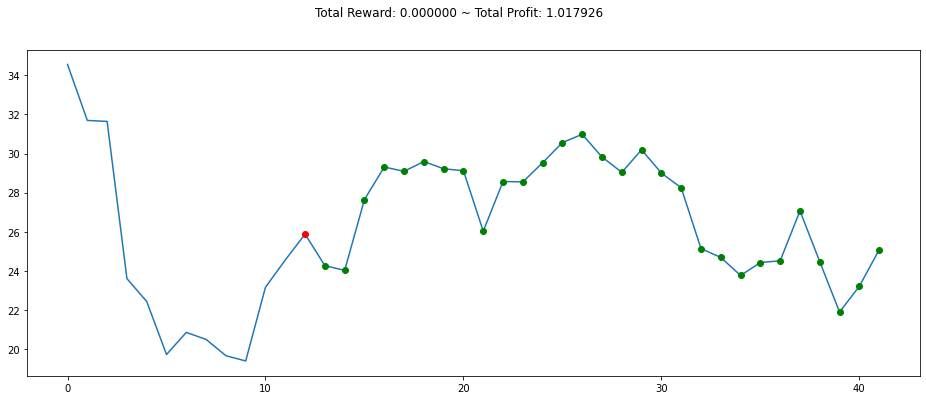

In [38]:
plt.figure(figsize=(16,6))
env.render_all()
plt.show()

After this algorithmic trading with custom indicators from the 130th day to the 160th day, we ended with a profit of 1.017926. We successfully obtained a net return compared to 0.984033 (loss).